# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

The input file is the zip file that is or will be added to each release.

In [1]:
from ppktstore.stats import PPKtStoreStats
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
stats = PPKtStoreStats(input_zipfile="all_phenopackets.zip")

Extracted 4876 phenopackets in 224 cohorts.


In [3]:
df = stats.get_df()
df.head(2)

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID
0,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual KCHYD24-1,ESAM,NM_138961.3:c.605T>G,NM_138961.3:c.605T>G,PMID:36996813
1,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 1,ESAM,NM_138961.3:c.115del,NM_138961.3:c.115del,PMID:36996813


In [4]:
stats_d = stats.get_descriptive_stats()
items = list()
for k,v in stats_d.items():
    items.append({"item": k, "value": v})
df = pd.DataFrame(items)
df.head(30)

Got 2705 unique HPOs


,item,value
0,phenopackets,4876
1,diseases,265
2,genes,225
3,alleles,2838
4,PMIDs,591
5,individuals per disease (max),463
6,individuals per disease (min),1
7,individuals per disease (mean),18.4
8,individuals per disease (median),7.0
9,genes associated with a single disease,202


# Display distribution of counts of phenopackets per disease

In [5]:
counts_per_disease = stats.get_counts_per_disease_df()
counts_per_disease.head(2)

,disease,count
0,OMIM:620371,14
1,OMIM:150250,3


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_with_max(
        disease_counts: pd.Series,
        max_val: int,
        ax=None,
        ):
    assert isinstance(max_val, int) and max_val > 0, '`max_val` must be a positive `int`'

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4), dpi=300)

    bins = list(range(1, max_val + 1)) + [disease_counts.max() + 1]
    labels = list(map(str, bins[:-2])) + [f'  ≥{max_val}']
    cats = pd.cut(
        x=disease_counts,
        bins=bins,
        labels=labels,
        right=False,
    )
    cat_count = cats.value_counts().sort_index()
    ax.bar(x=cat_count.index, height=cat_count.values)
    ax.set(
        xlabel='Number of cases',
        ylabel='Disease count',
    )
    ax.grid(axis='y')
    plt.xticks(np.arange(0, max_val, step=1))


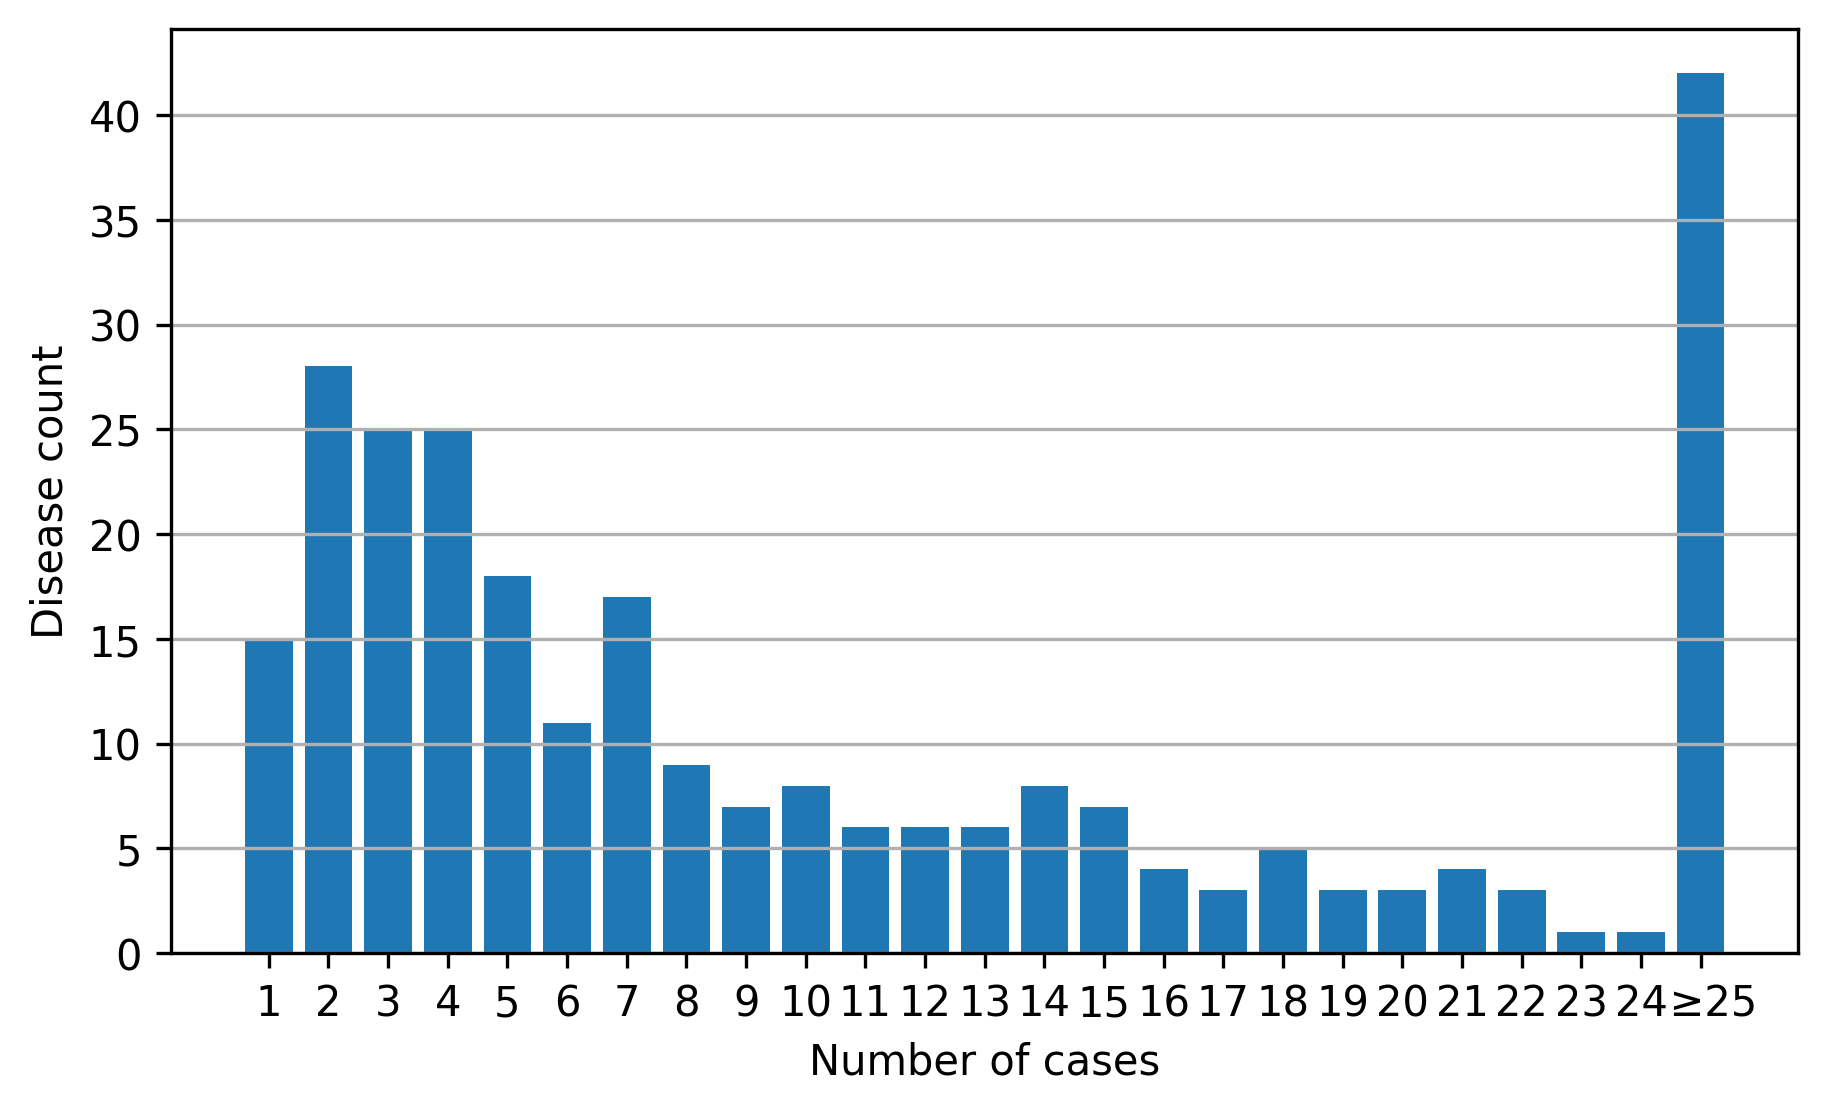

In [7]:
plot_with_max(
    disease_counts=counts_per_disease["count"],
    max_val=25,
)
plt.savefig('counts_per_disease.png')

# Check all disease identifiers
They should all be CURIEs with the prefixes OMIM or MONDO. There should be no whitespace between the colon and the suffix.

In [8]:
df = stats.check_disease_id()

No problems found.


# Check for duplicates
In some cases, duplicate phenopackets were inadvertently added to some of the initial cohorts at earlier stages of the project. This function lists phenopacket identifers arranged according to variant and allows us to more easily check for this kind of error.

In [9]:
input_zipfile="all_phenopackets.zip"
df = stats.show_possible_duplicates_by_variant(input_zipfile, "ERI1")

No candidate duplicates found for ERI1


# Quality control
The following commands perform several consistency checks.

In [10]:
df = stats.find_phenopackets_with_no_variants(input_zipfile=input_zipfile)

All phenopackets had at least one variant


In [11]:
stats.show_possible_duplicates_by_variant(input_zipfile, "ARPC5")

No candidate duplicates found for ARPC5


""


In [12]:
stats.find_phenopackets_with_no_disease(input_zipfile)

All phenopackets had a disease diagnosis


""
